Dataset shape: (144, 1)
Date range: 1949-01-01 00:00:00 to 1960-12-01 00:00:00

Baseline SARIMA Results
RMSE: 30.142008134932393
MAE: 23.55574505723697
Seq: 6 Hidden: 32 LR: 0.001 RMSE: 146.32193076184785
Seq: 6 Hidden: 32 LR: 0.01 RMSE: 92.59728309155459
Seq: 6 Hidden: 64 LR: 0.001 RMSE: 116.69393561524524
Seq: 6 Hidden: 64 LR: 0.01 RMSE: 114.91537732310894
Seq: 12 Hidden: 32 LR: 0.001 RMSE: 76.48373499476865
Seq: 12 Hidden: 32 LR: 0.01 RMSE: 84.81045329604865
Seq: 12 Hidden: 64 LR: 0.001 RMSE: 83.73770315507525
Seq: 12 Hidden: 64 LR: 0.01 RMSE: 81.28493840151138

Best Configuration:
Sequence Length: 12
Hidden Size: 32
Learning Rate: 0.001
Best RMSE: 76.48373499476865

LSTM + Attention Results
RMSE: 76.48373499476865
MAE: 56.31226348876953


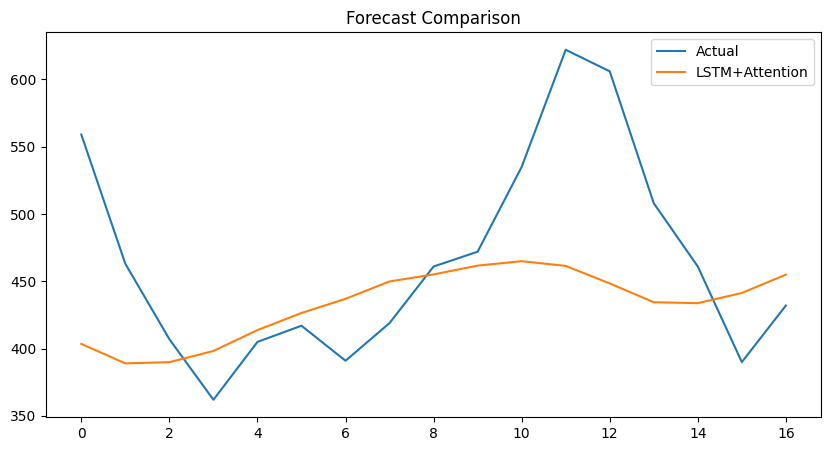

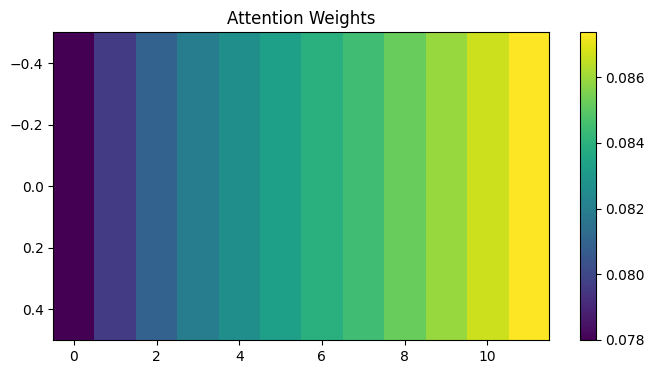


Files saved:
prediction_plot.png
attention_plot.png


In [1]:
# ================================
# COMPLETE TIME SERIES PROJECT
# SARIMA vs LSTM + Attention
# Includes Hyperparameter Search
# Saves Plots for Submission
# ================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import math
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

torch.manual_seed(42)
np.random.seed(42)

# ------------------------------
# 1. LOAD DATASET
# ------------------------------
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
df = pd.read_csv(url)

df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)

print("Dataset shape:", df.shape)
print("Date range:", df.index.min(), "to", df.index.max())

data = df['Passengers'].values.reshape(-1,1)

# ------------------------------
# 2. PREPROCESSING
# ------------------------------
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

train_size = int(len(data_scaled)*0.8)
train_data = data_scaled[:train_size]
test_data = data_scaled[train_size:]

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data)-seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# ------------------------------
# 3. BASELINE SARIMA
# ------------------------------
sarima_model = SARIMAX(data[:train_size], order=(1,1,1), seasonal_order=(1,1,1,12))
sarima_fit = sarima_model.fit(disp=False)
sarima_forecast = sarima_fit.forecast(steps=len(data)-train_size)

rmse_sarima = math.sqrt(mean_squared_error(data[train_size:], sarima_forecast))
mae_sarima = mean_absolute_error(data[train_size:], sarima_forecast)

print("\nBaseline SARIMA Results")
print("RMSE:", rmse_sarima)
print("MAE:", mae_sarima)

# ------------------------------
# 4. MODEL DEFINITION
# ------------------------------
class AttentionModel(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.attention = nn.Linear(hidden_size, 1)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        attn_weights = torch.softmax(self.attention(lstm_out), dim=1)
        context = torch.sum(attn_weights * lstm_out, dim=1)
        out = self.fc(context)
        return out, attn_weights

# ------------------------------
# 5. HYPERPARAMETER SEARCH
# ------------------------------
hidden_sizes = [32, 64]
learning_rates = [0.001, 0.01]
seq_lengths = [6, 12]

best_rmse = float("inf")
best_config = None
best_model = None
best_seq_length = None

for seq_length in seq_lengths:
    X_train, y_train = create_sequences(train_data, seq_length)
    X_test, y_test = create_sequences(test_data, seq_length)

    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)

    for hidden_size in hidden_sizes:
        for lr in learning_rates:

            model = AttentionModel(1, hidden_size)
            criterion = nn.MSELoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)

            for epoch in range(100):
                model.train()
                optimizer.zero_grad()
                output, _ = model(X_train)
                loss = criterion(output, y_train)
                loss.backward()
                optimizer.step()

            model.eval()
            predictions, attn_weights = model(X_test)
            predictions = predictions.detach().numpy()
            predictions = scaler.inverse_transform(predictions)
            y_test_inv = scaler.inverse_transform(y_test.detach().numpy())

            rmse = math.sqrt(mean_squared_error(y_test_inv, predictions))

            print("Seq:", seq_length,
                  "Hidden:", hidden_size,
                  "LR:", lr,
                  "RMSE:", rmse)

            if rmse < best_rmse:
                best_rmse = rmse
                best_config = (seq_length, hidden_size, lr)
                best_model = model
                best_seq_length = seq_length
                best_predictions = predictions
                best_y_test = y_test_inv
                best_attention = attn_weights.detach().numpy()

# ------------------------------
# 6. FINAL RESULTS
# ------------------------------
print("\nBest Configuration:")
print("Sequence Length:", best_config[0])
print("Hidden Size:", best_config[1])
print("Learning Rate:", best_config[2])
print("Best RMSE:", best_rmse)

mae_lstm = mean_absolute_error(best_y_test, best_predictions)

print("\nLSTM + Attention Results")
print("RMSE:", best_rmse)
print("MAE:", mae_lstm)

# ------------------------------
# 7. SAVE PREDICTION PLOT
# ------------------------------
plt.figure(figsize=(10,5))
plt.plot(best_y_test, label="Actual")
plt.plot(best_predictions, label="LSTM+Attention")
plt.legend()
plt.title("Forecast Comparison")
plt.savefig("prediction_plot.png")
plt.show()

# ------------------------------
# 8. SAVE ATTENTION PLOT
# ------------------------------
plt.figure(figsize=(8,4))
plt.imshow(best_attention[0].T, aspect='auto')
plt.colorbar()
plt.title("Attention Weights")
plt.savefig("attention_plot.png")
plt.show()

print("\nFiles saved:")
print("prediction_plot.png")
print("attention_plot.png")
